In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./MOVIE'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./MOVIE\Genre Classification Dataset\description.txt
./MOVIE\Genre Classification Dataset\test_data.txt
./MOVIE\Genre Classification Dataset\test_data_solution.txt
./MOVIE\Genre Classification Dataset\train_data.txt


In [ ]:
%pip install nltk
%pip install contractions

In [ ]:
%pip install sumy

In [15]:
# we get the data , training and testing , we combine the title and the description  , we use both the tf-idf and n-grams since 2~3 words 
# sequences appear to have considerable meaning
# then we train few models and we see :O ;)

train_data = pd.read_csv('./Movie/Genre Classification Dataset/train_data.txt',encoding='ISO-8859-1',delimiter=":::",engine="python",header=None)
test_data = pd.read_csv('./Movie/Genre Classification Dataset/test_data_solution.txt',encoding='ISO-8859-1',delimiter=":::",engine="python",header=None)


#Trying with smaller samples from the dataset then growing up in consumption to quickly `debug` the models
train_data = train_data.sample(frac=0.4)
test_data = test_data.sample(frac=0.3)




# X_train  = train_data[1] + train_data[3]
# X_train.head()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import contractions



def preprocess_text(text):
    
    text = text.lower()
    # Now we try to expand contractions such is "it's" , "they're" ...
    text = contractions.fix(text)

    # As a precaution we also remove URLs , punctuiations and numbers
    text = re.sub(r'http\S+|www\S+|@\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])

    # A nessecary step soo we can utilize funcs of removing stop words and lemmatize the words of the document (StopWords such as : a , an , to , also ...etc)
    tokens = word_tokenize(text)

    # handling stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Handling Lemmatization (Keeping only the root of the words for less dimensions)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    #A reverse step to go back from tokens to text
    text = ' '.join(tokens)

    return text


# Text Summarization

import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer

def summarize_text(text, num_sentences=1):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return " ".join([str(sentence) for sentence in summary])




In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21686 entries, 8318 to 21884
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       21686 non-null  int64 
 1   1       21686 non-null  object
 2   2       21686 non-null  object
 3   3       21686 non-null  object
dtypes: int64(1), object(3)
memory usage: 847.1+ KB


In [30]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16260 entries, 22688 to 40186
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       16260 non-null  int64 
 1   1       16260 non-null  object
 2   2       16260 non-null  object
 3   3       16260 non-null  object
dtypes: int64(1), object(3)
memory usage: 635.2+ KB


In [ ]:

X_train = train_data[3]


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data[[2]])

# X_test = test_data[1] + test_data[3]
X_test = test_data[3]

# Text Pre-Processing
This step involves text cleaning , basic text transformation , lemmatization and  summarizing the text for better model performance

In [33]:
X_train = X_train.apply(lambda x : summarize_text(preprocess_text(x)))
X_test = X_test.apply(lambda x : summarize_text(preprocess_text(x)))

# Visualizing labels : 


C:\Users\SEGMATECH\AppData\Local\Temp\ipykernel_15836\359710385.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\Program Files\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


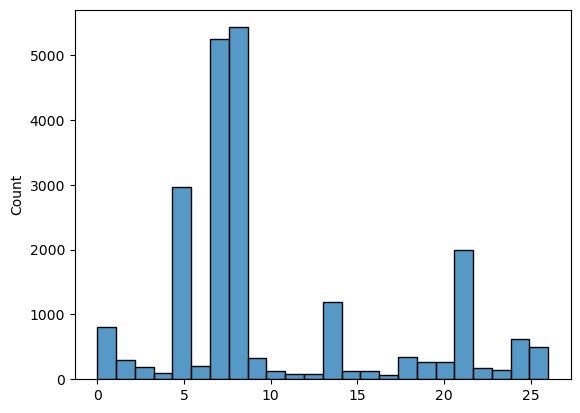

In [34]:
with pd.option_context('mode.use_inf_as_na', True):
    sns.histplot(y_train, bins=24)
    plt.show()

# Vectorization & Handling Imbalanced Data
for Vectorization we played arround with TfidfVectorizer combined with n-grams , how ever the performance wasn't worth it so stuck with simple TF-IDF Vectorizer
we chose to use oversampling as a way to handle the the imbalance in the data , and that's due to the small sample size for the each labels (max arround 4k and min of 36)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

# vectorizer = TfidfVectorizer(ngram_range=(1, 3))
vectorizer = TfidfVectorizer(max_features=20000)
X_train_vectorized = vectorizer.fit_transform(X_train)


# resampling
X_train_vectorized , y_train = smote.fit_resample(X_train_vectorized , y_train)



#use the already fitted model from the training data
X_test_vectorized = vectorizer.transform(X_test)
y_test = label_encoder.transform(test_data[[2]])


In [20]:
X_train.iloc[0]

'science fiction movie placed future tale past man fate twisted vast scenery reaching billion year past edge existence future movie debut richard schweiger written produced filmed animated composed music'

In [21]:
X_train.shape

(21686,)

In [22]:
X_test.shape

(16260,)

In [ ]:
y_train.value_counts()

array([ 8, 24,  7, ...,  7,  7,  7])

In [ ]:
X_test_vectorized

<16260x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 695522 stored elements in Compressed Sparse Row format>

In [ ]:
%pip install xgboost

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_auc_score


In [24]:
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)

y_pred = nb_classifier.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)

# print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy)
# print(f"ROC-AUC: {roc_auc_score(y_test, y_pred)}")

print(classification_report(y_test, y_pred))

Accuracy: 0.5051045510455104
              precision    recall  f1-score   support

           0       0.29      0.46      0.35       400
           1       0.40      0.51      0.45       162
           2       0.29      0.23      0.26       228
           3       0.21      0.24      0.22       127
           4       0.02      0.03      0.02        77
           5       0.58      0.47      0.52      2252
           6       0.16      0.26      0.20       151
           7       0.73      0.66      0.70      3909
           8       0.64      0.50      0.56      4041
           9       0.21      0.22      0.21       263
          10       0.13      0.16      0.14        98
          11       0.64      0.72      0.68        58
          12       0.01      0.01      0.01        67
          13       0.48      0.71      0.58       656
          14       0.33      0.72      0.45       217
          15       0.12      0.11      0.12        71
          16       0.06      0.06      0.06        8

In [28]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=100, random_state=0)
clf.fit(X_train_vectorized,y_train)
predicted_proba = clf.predict_proba(X_test_vectorized)
y_pred = clf.predict(X_test_vectorized)
score = clf.score(X_test_vectorized, y_test)
accuracy = accuracy_score(y_test, y_pred)
cs_report = classification_report(y_test,y_pred)

print("Accuracy:", accuracy)
print('Classification Report :\n',cs_report)

Accuracy: 0.4883148831488315
Classification Report :
               precision    recall  f1-score   support

           0       0.47      0.13      0.20       400
           1       0.41      0.36      0.39       162
           2       0.64      0.18      0.28       228
           3       0.40      0.14      0.21       127
           4       0.00      0.00      0.00        77
           5       0.47      0.30      0.37      2252
           6       0.29      0.01      0.03       151
           7       0.56      0.81      0.66      3909
           8       0.44      0.68      0.53      4041
           9       0.68      0.06      0.11       263
          10       0.50      0.02      0.04        98
          11       0.85      0.59      0.69        58
          12       0.00      0.00      0.00        67
          13       0.50      0.49      0.49       656
          14       0.48      0.52      0.50       217
          15       0.19      0.08      0.12        71
          16       1.00    

e:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=2*1000).fit(X_train_vectorized, y_train)
predicted_proba = clf.predict_proba(X_test_vectorized)
y_pred = clf.predict(X_test_vectorized)
score = clf.score(X_test_vectorized, y_test)
accuracy = accuracy_score(y_test, y_pred)
cs_report = classification_report(y_test,y_pred)

print("Accuracy:", accuracy)
print('Classification Report :\n',cs_report)

e:\Program Files\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Accuracy: 0.5479704797047971
Classification Report :
               precision    recall  f1-score   support

           0       0.38      0.29      0.33       400
           1       0.58      0.36      0.44       162
           2       0.46      0.22      0.30       228
           3       0.31      0.16      0.21       127
           4       0.00      0.00      0.00        77
           5       0.50      0.52      0.51      2252
           6       0.33      0.10      0.15       151
           7       0.68      0.76      0.72      3909
           8       0.52      0.70      0.60      4041
           9       0.39      0.16      0.23       263
          10       0.30      0.09      0.14        98
          11       0.80      0.60      0.69        58
          12       0.00      0.00      0.00        67
          13       0.63      0.61      0.62       656
          14       0.62      0.47      0.53       217
          15       0.00      0.00      0.00        71
          16       0.18    